# DAT 435 Final Project
## Analyzing the Relationship Between Drought and Wild Fires in the US
### By: Philip Krause

### References
#### Research sources
Westerling, Anthony LeRoy. “Increasing Western US Forest Wildfire Activity: Sensitivity to Changes in the Timing of Spring.” Philosophical Transactions of the Royal Society of London. Series B. Biological Sciences, vol. 371, no. 1696, 2016, pp. 20150178-, https://doi.org/10.1098/rstb.2015.0178. <br>
<br>
Wildfire Climate Connection, National Oceanic and Atmospheric Administration, 24 July 2023, www.noaa.gov/noaa-wildfire/wildfire-climate-connection. 

#### Data sources
- Wildfire spatial data taken from data.gov:
https://catalog.data.gov/dataset/national-usfs-fire-occurrence-point-feature-layer-d3233
<br>
- Drought data taken from the US drought monitor: https://droughtmonitor.unl.edu/DmData/GISData.aspx
<br>
- County and state geometries and data taken from census.gov

### Abstract
<br>
This project explores the relationship between drought and the occurance of wild fires in the United States. It makes use of several spatial plots that explore drought conditions and wild fire numbers and sizes to give a visual representation of the relationship between the two. It also uses US county data to explore a more quantitative relationship and gives a general look at the change in wild fires over time. The spatial plots show a clear correlation between drought conditions and wild fires while also showing that there are many more factors that must be considered when analyzing wild fires. The quantitative analysis further shows both of these points, with a clear positive correlation. Finally, the analysis of wild fire impact over time shows a clear increase in wild fires, beginning aroung the 1980's, which confirms what previous research has indicated. 

### Introduction

The beginning of 2025 saw some of the most destructive fires in history hit California and issues surrounding forest fires were brought to the public's attention. From an outside perspective, it often appears that destructive forest fires are becoming more common and more impactful. Agencies and orgnizations that study such events have used data to show that fires are, in fact, becoming larger and have pointed at climate change as a possible reason why. The National Oceanic and Atmospheric Administration cites a 2016 study which found that "climate change enhanced the drying of organic matter and doubled the number of large fires between 1984 and 2015" (Wildfire Climate Connection). A concept involved in the connection between climate change and forest fires is drought. One study states that "the largest fires years occur in years with warm spring and summer temperatures and early spring snowmelt dates" (Westerling). Hotter temperatures and lack of water clearly impact the presence and impact of forest fires and this project intends to further examine this intersection. Data on drought levels and fire occurances will be used to analyze any relationship that exists between the two.

### Methods
<br>
In addition to the methods shown here, further methods for utilizing and anlyzing data will be shown throughout the project.

In [1]:
# Importing necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\phikr\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Census.gov provides spatial data on the states and counties of the United States. In this project, I will be using this data to sort my other data sets by location and to provide background geometries. Here, I am reading the data and formatting it to fit my needs.

In [129]:
# Getting border geometries
url_county = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip'
url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip'

county_gdf = gpd.read_file(url_county)
state_gdf = gpd.read_file(url_state)

# Changing the crs of borders
county_gdf = county_gdf.to_crs(5070)
state_gdf = state_gdf.to_crs(5070)

# Using only the CONUS
exclude_list = [15, 72, 2, 60, 66, 69, 78]
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]
county_gdf = county_gdf.loc[~county_gdf['STATEFP'].astype(int).isin(exclude_list)]

# Combining county and state FPs
county_gdf['FIPS'] = county_gdf.STATEFP + county_gdf.COUNTYFP

My next source of data is data.gov (https://catalog.data.gov/dataset/national-usfs-fire-occurrence-point-feature-layer-d3233). Here, I have taken data concerning the points of origin from which individual USFS wildland fires started. It spans many years, but this project will look more at data of the 21st century. Here, I am reading this data and fine tuning it for my use. The raw data included latitude and longitude points which I am converting into point geometries and then getting to match my crs.

In [130]:
fire_df = pd.read_csv('National_USFS_Fire_Occurrence_Point_(Feature_Layer).csv')

# To get rid of any warnings and to simplify data, I will reduce it to these columns
fire_df = fire_df[['DISCOVERYDATETIME','FIREYEAR','TOTALACRES','LATDD83','LONGDD83']]
# Reduce to actual years
fire_df = fire_df[(fire_df['FIREYEAR'] > 1910) & (fire_df['FIREYEAR'] < 2026)]
# Make year values ints
fire_df['FIREYEAR'] = fire_df['FIREYEAR'].astype(int)

# This data includes LAT and LON values, so I will convert them to point geometries
fire_gdf = gpd.GeoDataFrame(fire_df, geometry = gpd.points_from_xy(fire_df.LONGDD83, fire_df.LATDD83), crs="EPSG:4326")

# Converting the crs to match my state geometries
fire_gdf = fire_gdf.to_crs('EPSG:5070') 
fire_gdf.head()

C:\Users\phikr\AppData\Local\Temp\ipykernel_10532\3493565169.py:1: DtypeWarning: Columns (5,11,12,13,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  fire_df = pd.read_csv('National_USFS_Fire_Occurrence_Point_(Feature_Layer).csv')


DISCOVERYDATETIME  FIREYEAR  TOTALACRES   LATDD83   LONGDD83  \
0  2016/10/22 00:00:01+00      2016        0.25  39.84611 -106.42778   
1  2016/08/07 00:00:01+00      2016        0.10  39.37278 -107.93556   
2  1997/07/26 00:00:01+00      1997        0.10  39.11833 -106.72333   
3  1993/08/23 00:00:01+00      1993        0.10  39.65667 -106.59000   
4  2020/10/14 13:16:01+00      2020        0.10  40.01929 -107.31731   

                           geometry  
0   POINT (-882544.776 1918202.572)  
1  POINT (-1016169.689 1880586.821)  
2   POINT (-916637.266 1839943.251)  
3   POINT (-898578.357 1898623.981)  
4   POINT (-955181.693 1946081.565)

In order to make my plots more readable and to simplify the data, I have constructed a geometry that encloses the contiguous United States (CONUS). Intersecting this geometry with my data will exclude any points that are from outside this area.

In [131]:
# Making geometry that encapsulates the CONUS
from shapely.geometry import box

# From previous plot, I can see the rough dimensions needed
min_y, max_y = 0, 3500000
min_x, max_x = -2500000, 2500000

# Making it into a box
conus_box = box(minx=min_x, miny=min_y, maxx=max_x, maxy=max_y)

# Making it into a geo dataframe with same crs as data
box_gdf = gpd.GeoDataFrame(index=[0], geometry=[conus_box], crs=fire_gdf.crs)

# Intersecting with data to only get shared values
fire_gdf = gpd.overlay(fire_gdf, box_gdf, how="intersection")

The third source of data is the US drought monitor (https://droughtmonitor.unl.edu/DmData/GISData.aspx). They provide many spatial data sets for certain days from 2000 to the present. These data sets show 5 levels of drought. D0 means Abnormally Dry, D1 means Moderate Drought, D2 means Severe Drought, D3 means Extreme Drought, and D4 means Exceptional Drought. In this project, I will use data from three different years to help understand the relationship between drought and wild fires. Data cleaning and processing will be shown in future cells.

### Results and Discussion

To begin, I am going to look at all the fires in the dataset starting from the year 2019. These will be organized by year and the points will vary in size based on the total acres covered by the fire. This plot will help to give an introductory look into how big of a problem fires are in this country.

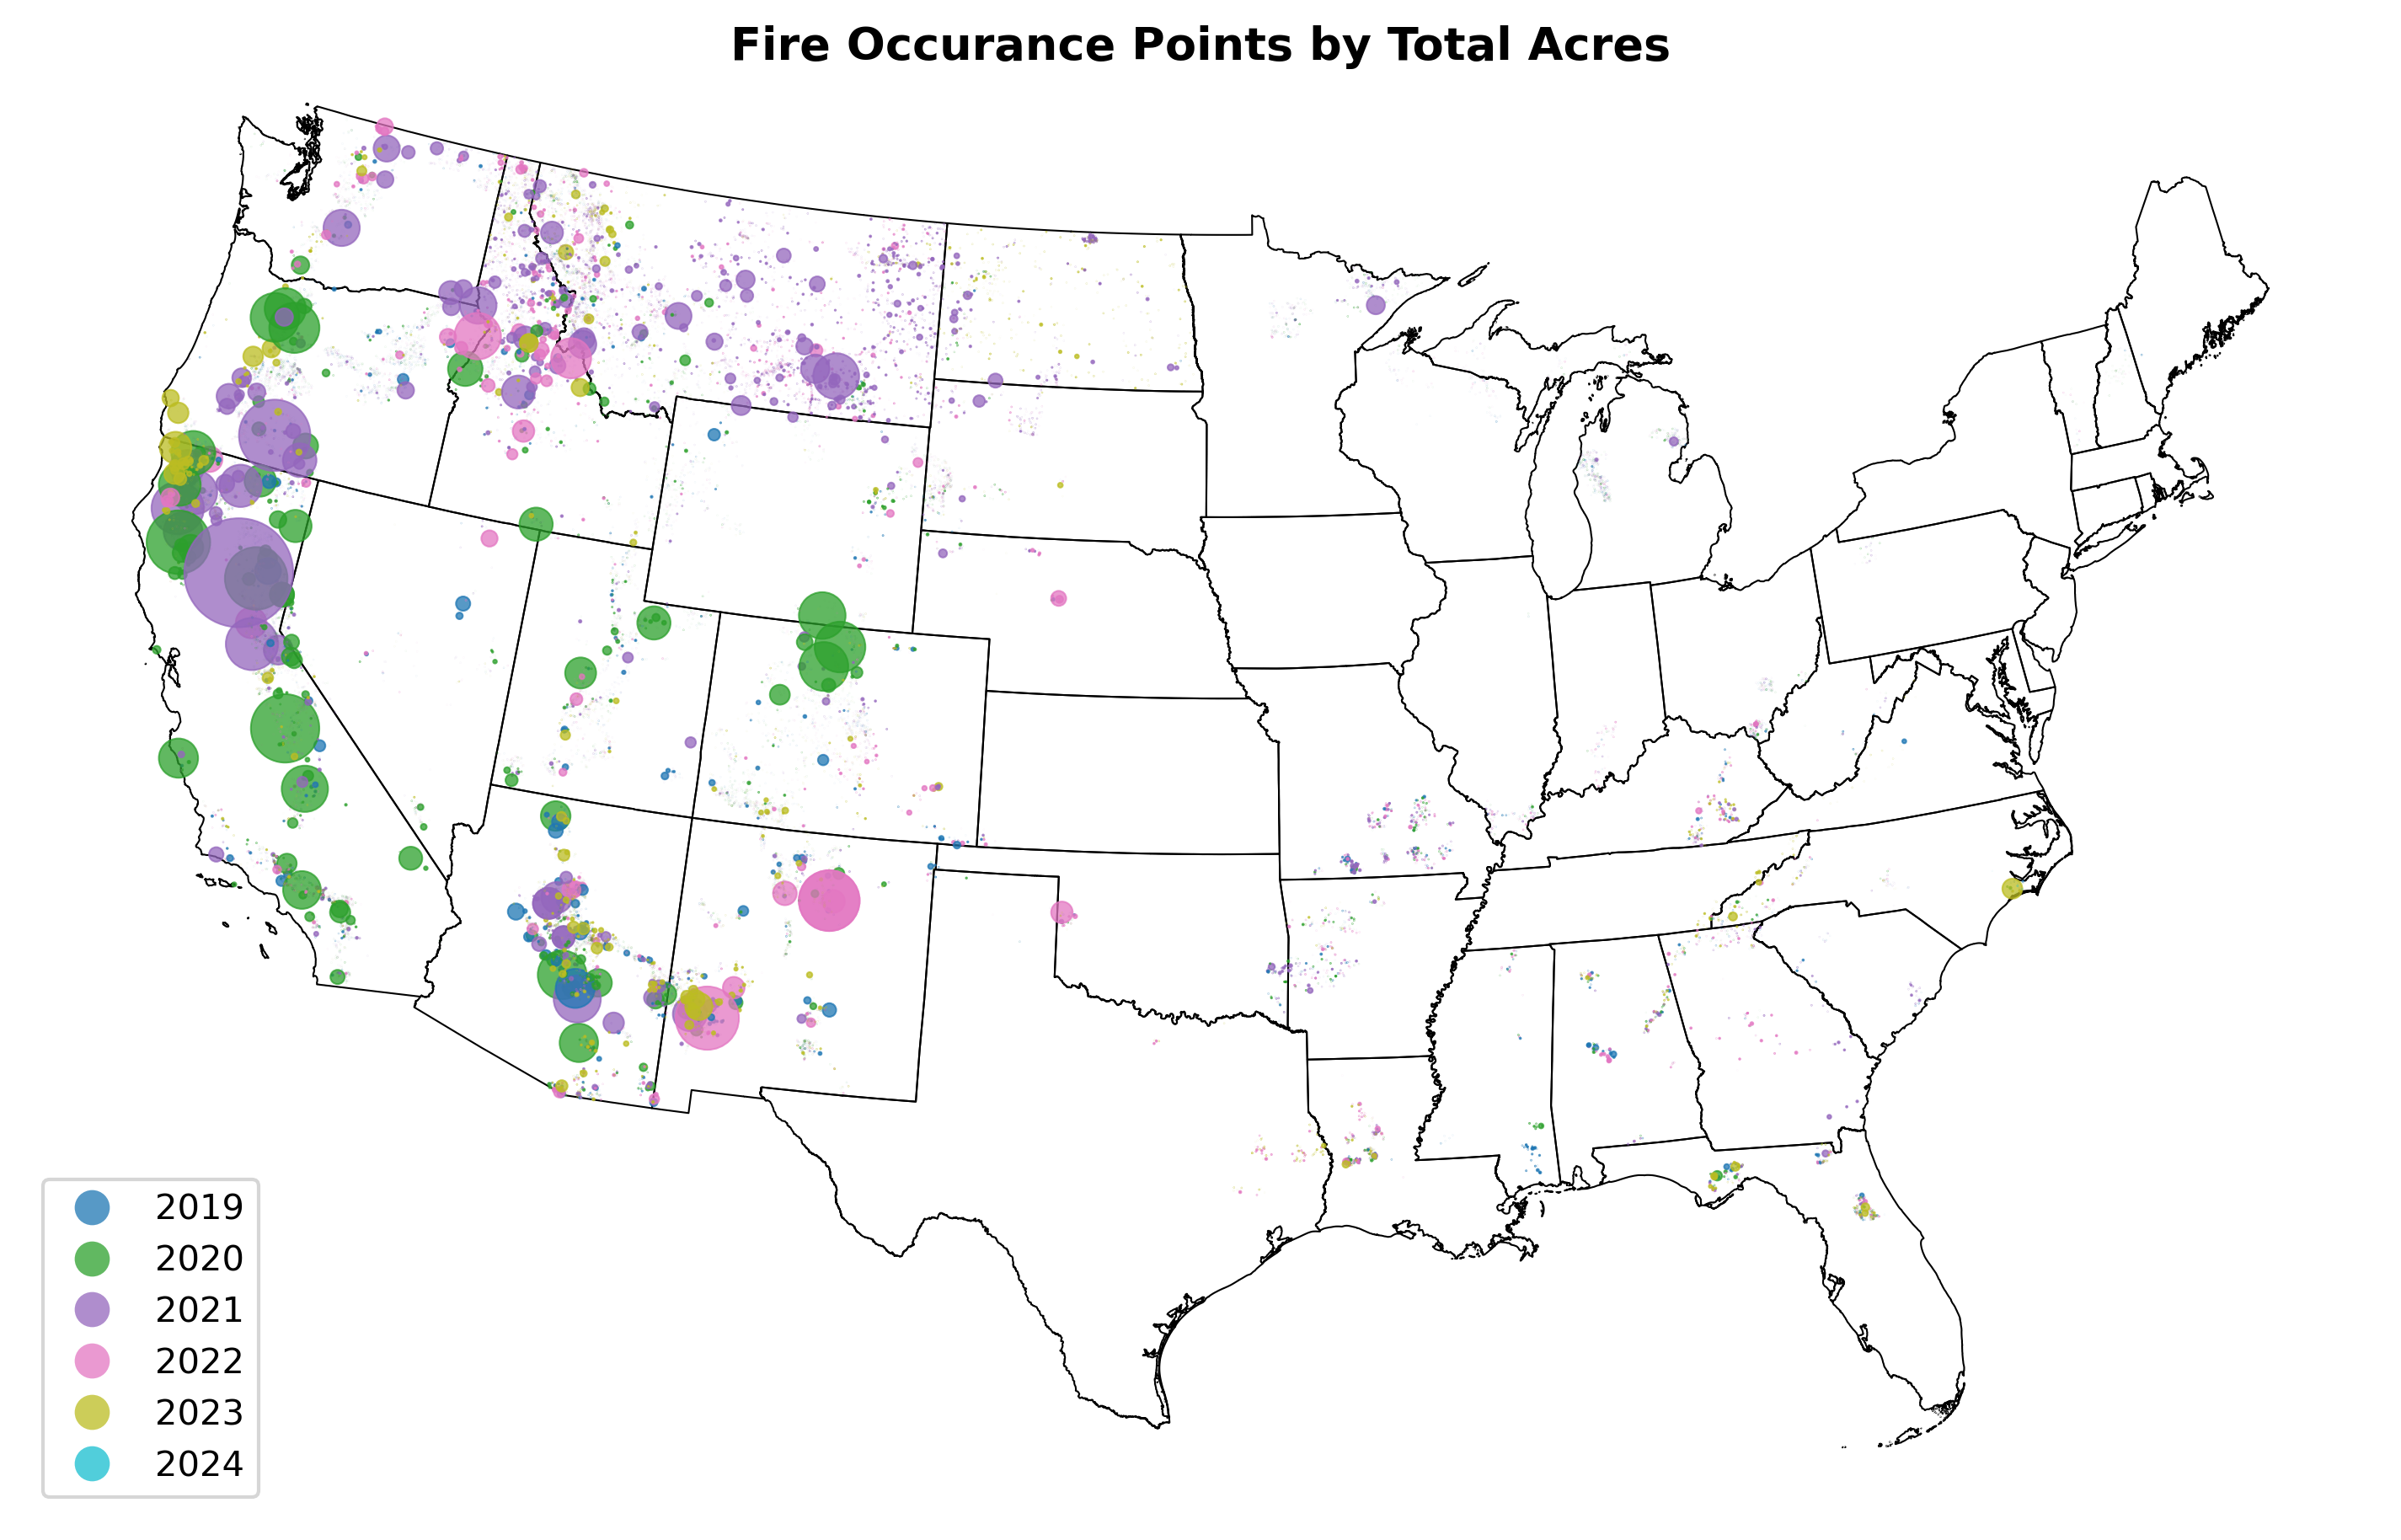

In [132]:
# Plotting all fires with markersize representing total acres affected and colors representing year

# There is a lot of data in this set, so I will just look at years 2019+
recent_fire_gdf = fire_gdf.copy()
recent_fire_gdf = recent_fire_gdf.loc[(fire_gdf['FIREYEAR']>2018) & (fire_gdf['FIREYEAR']<2026)]

fig, ax1 = plt.subplots(1, 1, figsize=(12, 12), dpi=300)

# Converting year to a string to make legend work correctly
recent_fire_gdf['FIREYEAR_STR'] = recent_fire_gdf['FIREYEAR'].astype(str)

state_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', facecolor='none')

recent_fire_gdf.plot(ax=ax1, column = 'FIREYEAR_STR', markersize = recent_fire_gdf['TOTALACRES']/1000, linewidth = 0.5, 
              edgecolor = 'face', alpha = 0.75, legend = True, aspect=1,  legend_kwds={'loc': 'lower left', 'fontsize': 10})

ax1.set_axis_off()
ax1.set_title('Fire Occurance Points by Total Acres', fontweight='bold', y=.97, fontsize=13);

This plot gives a good picture on the extent of wildfires in the past 6 years. These fires are much more present in the west and certainly cover more area in the west as well. This data seems to show that 2020 and 2021 had the largest fires of the years shown. In order to better understand the relationship between droughts and these fires, I will bring in drought maps that will be overlayed with fire data points. 

#### Looking at 2021

The previous plot showed that 2021 had many large wild fires, so now I will compare a drought map from the summer of 2021 to the map of fires in that year. Doing so will help visualize any relationship that may exist between the two. Because there are so many points of data, many of which are very small fires, I will only look at fires that exceeded 1,000 acres in size. 

In [133]:
# Creating 2021 gdf with values over 1,000 acres
twone_gdf = fire_gdf.loc[fire_gdf['FIREYEAR'] == 2021]
twone_gdf = twone_gdf.loc[twone_gdf['TOTALACRES'] > 1000]
twone_gdf = twone_gdf.sort_values(by='TOTALACRES', ascending = False)
twone_gdf.head()

DISCOVERYDATETIME  FIREYEAR  TOTALACRES   LATDD83   LONGDD83  \
569961  2021/07/14 00:15:02+00      2021    963309.0  39.87600 -121.37883   
442558  2021/07/06 13:42:00+00      2021    413717.0  42.61592 -121.42091   
304927  2021/07/31 01:10:00+00      2021    223124.0  40.75228 -123.33680   
273625  2021/08/14 00:00:00+00      2021    221835.0  38.61643 -120.58883   
164289  2021/06/04 14:37:00+00      2021    180757.0  33.21234 -111.12351   

                                geometry  
569961   POINT (-2125853.79 2158639.509)  
442558  POINT (-2048228.149 2455374.929)  
304927  POINT (-2257632.471 2298217.683)  
273625  POINT (-2097306.437 2004769.495)  
164289  POINT (-1394829.337 1238216.215)

Here, I am reading data from the US Drought Monitor. This specifically is the drought data from July 13th, 2021. Unfortunately, this source does not have year-long or month-long average data, so I will have to use a specific day. I chose this date because many of the fire data points occured in the months of summer, specifically in July. While it is true that drought conditions change throughout the year and that this is will not be the most accurate generalization possible, hopefully it will still give a good picture of the relationship between drought and wild fires. 

In [148]:
# Reading data from link
url_name = r'https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_20210713_M.zip'

drought_twone_gdf = gpd.read_file(url_name)

# Adding explanations of drought levels to data frame
DM_dict = {0: '0: Abnormally Dry', 1: '1: Moderate Drought', 2: '2: Severe Drought',
             3: '3: Extreme Drought', 4: '4: Exceptional Drought'}

drought_twone_gdf['DM_str'] = [DM_dict[i] for i in drought_twone_gdf['DM'].values]

drought_twone_gdf.head()

OBJECTID  DM    Shape_Leng    Shape_Area  \
0         1   0  4.450497e+07  1.119648e+12   
1         2   1  3.656680e+07  7.386279e+11   
2         3   2  3.666712e+07  1.006820e+12   
3         4   3  3.167702e+07  1.113286e+12   
4         5   4  1.313748e+07  7.693401e+11   

                                            geometry                  DM_str  
0  MULTIPOLYGON (((-67.17698 18.00918, -67.17753 ...       0: Abnormally Dry  
1  MULTIPOLYGON (((-66.90909 17.95065, -66.90948 ...     1: Moderate Drought  
2  MULTIPOLYGON (((-104.22221 30.68503, -104.0589...       2: Severe Drought  
3  MULTIPOLYGON (((-103.47122 33.13241, -103.5586...      3: Extreme Drought  
4  MULTIPOLYGON (((-104.84586 32.21714, -104.9626...  4: Exceptional Drought

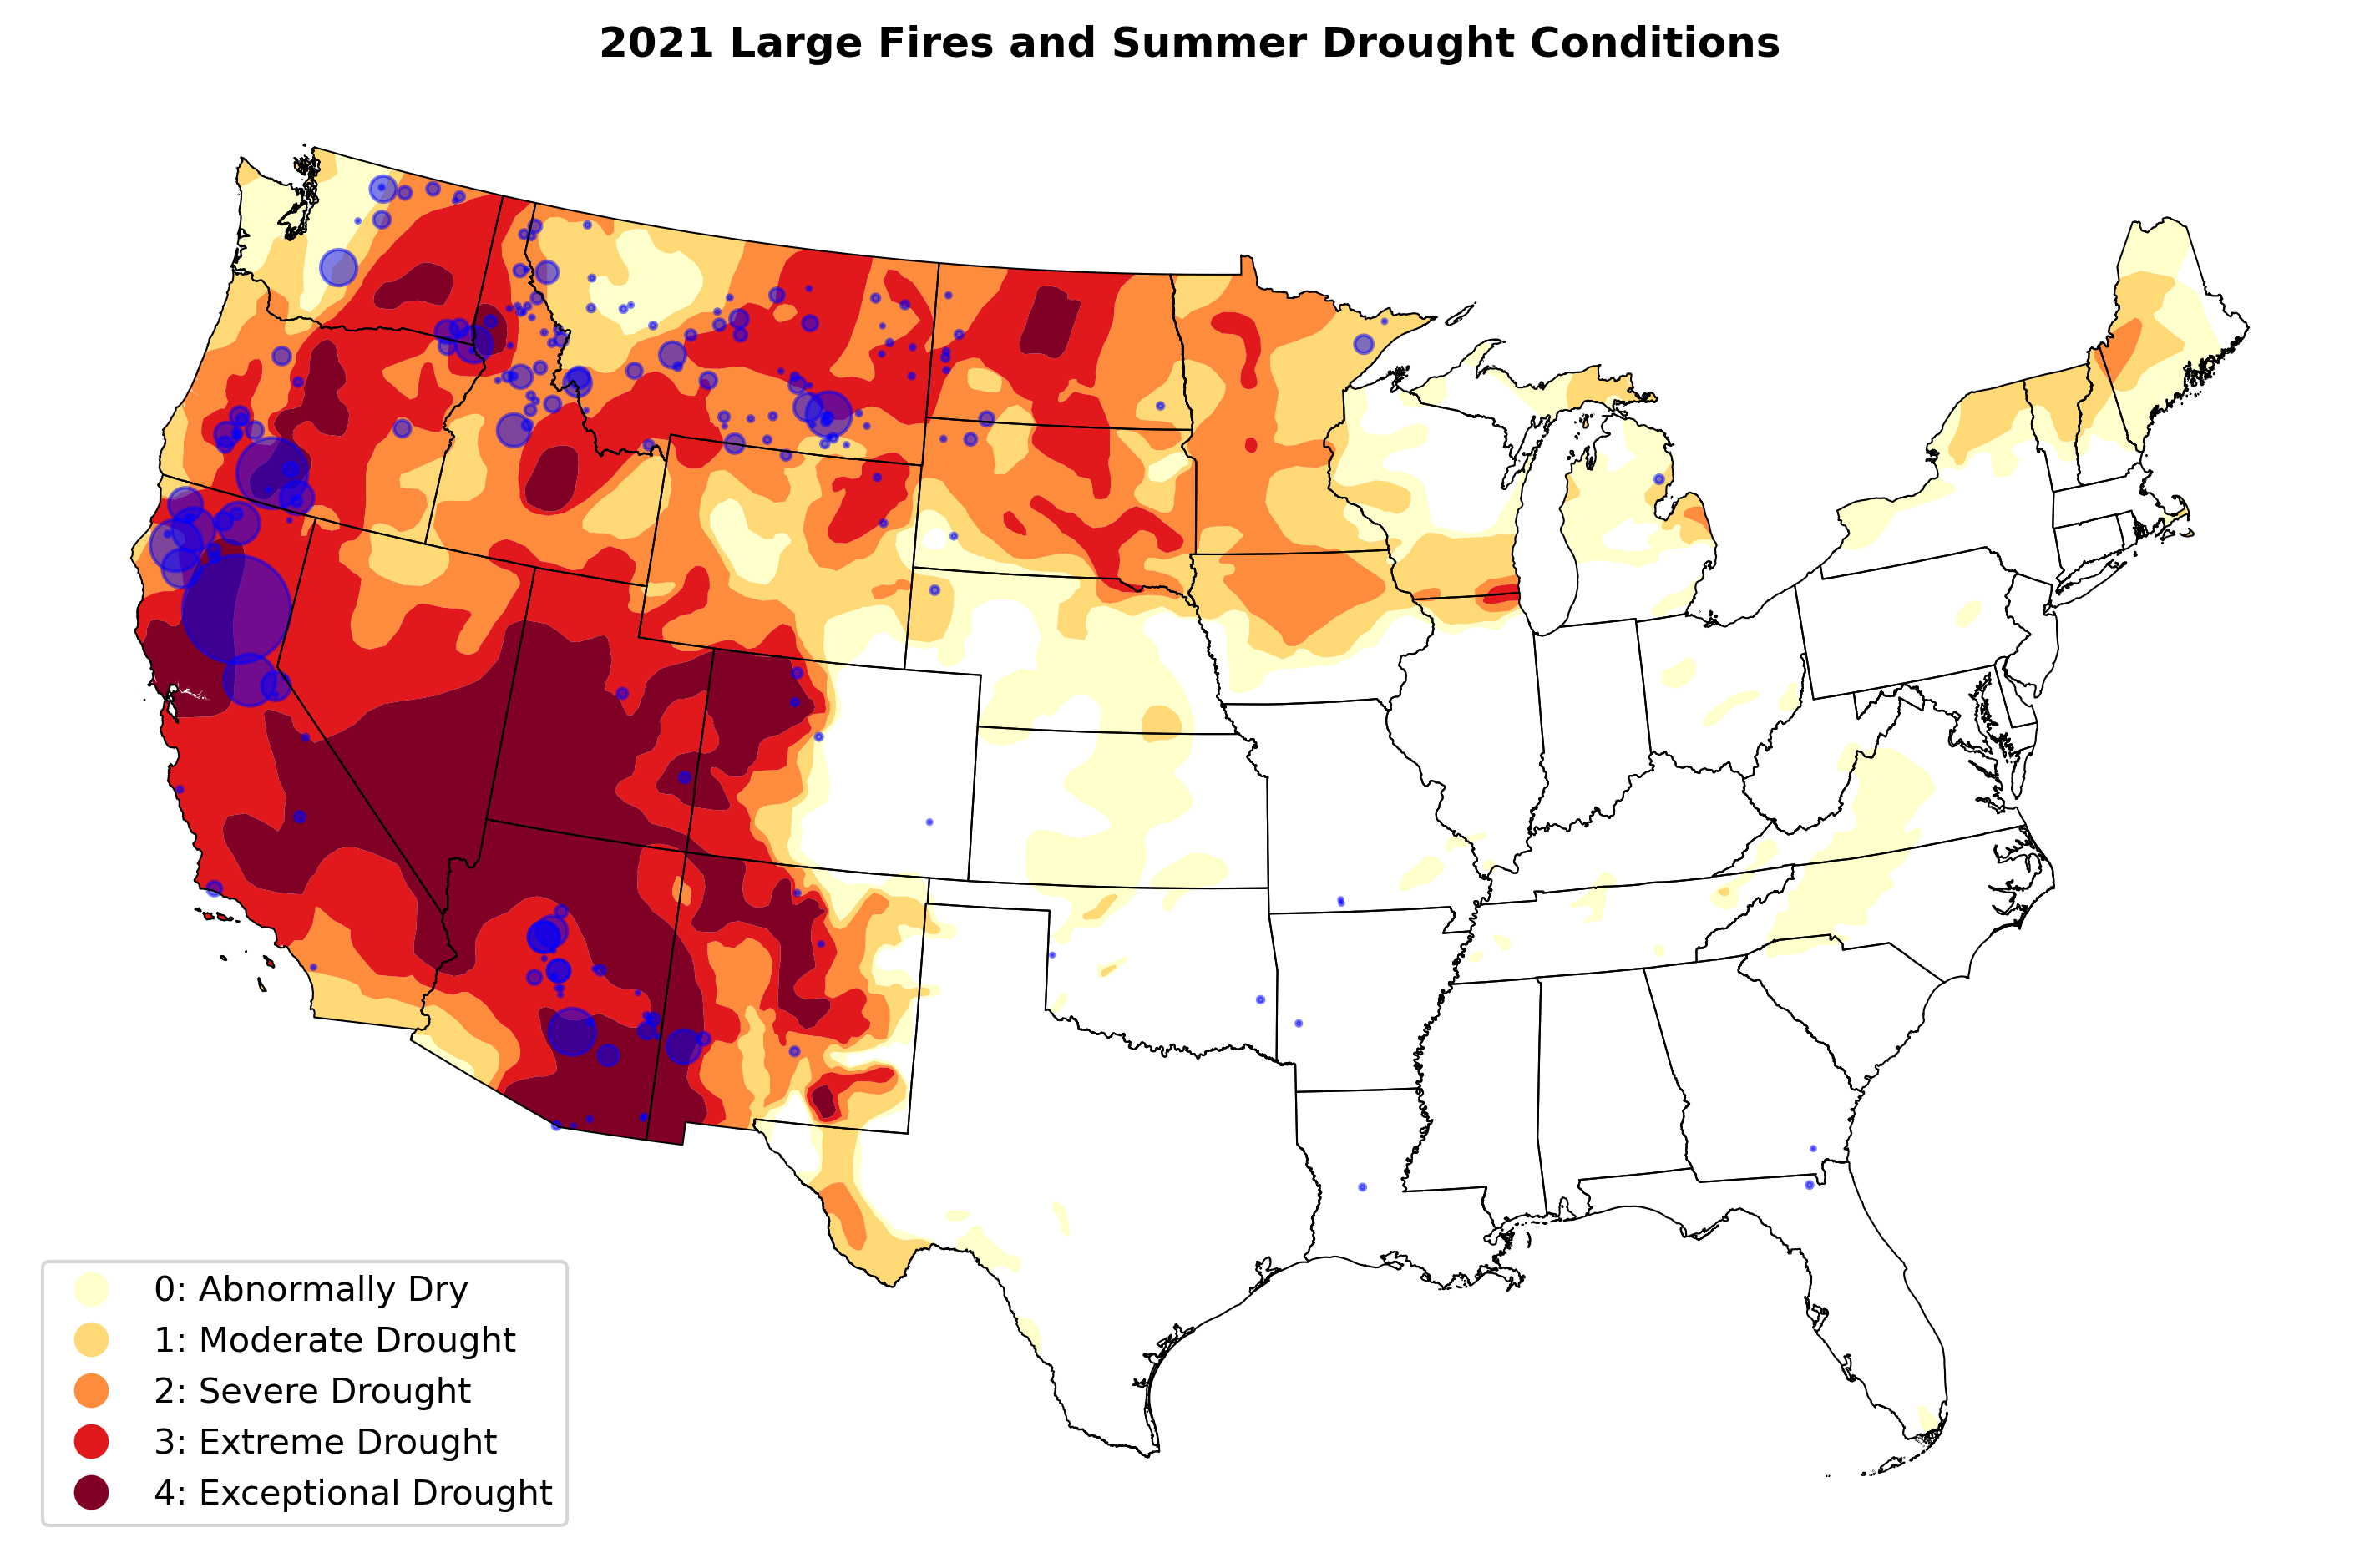

In [150]:
# Making sure crs is correct and then overlaying data with CONUS
drought_twone_gdf = drought_twone_gdf.to_crs('EPSG:5070')
drought_twone_gdf = gpd.overlay(drought_twone_gdf, box_gdf, how="intersection")

# Plotting drought and fire data in same plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12), dpi=300)

drought_twone_gdf.plot(ax = ax1, column = 'DM_str',legend=True, cmap = 'YlOrRd', 
                       legend_kwds={'loc': 'lower left', 'fontsize': 10})

twone_gdf.plot(ax=ax1, markersize = twone_gdf['TOTALACRES']/1000, alpha = 0.5, color = 'blue')
state_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', facecolor='none')

ax1.set_title('2021 Large Fires and Summer Drought Conditions', weight= 'bold')
ax1.set_axis_off()

This is a very informative and revealing plot. You can see that the summer of 2021 saw large parts of the country, specifically in the west, experiencing drought. The fire data follows this pattern rather closely. Almost every single location of a wild fire is in an area that was experiencing some level of drought. In areas of California and Arizona, you can even see some clumping of fires in areas that were experiencing severe drought. This clearly shows a correlation between drought and wild fire occurance, but to get a better understanding, I will look at two additional years, each a decade earlier.

#### Looking at 2010
By looking at years past, I hope to be able to see how things may be changing with regards to drought and wild fires. Here, I will compare the drought map of July 13th, 2010 to the fire locations of that year. This will be the same procedure as the previous plot.

In [136]:
ten_gdf = fire_gdf.loc[fire_gdf['FIREYEAR'] == 2010]
ten_gdf = ten_gdf.loc[ten_gdf['TOTALACRES'] > 1000]
ten_gdf = ten_gdf.sort_values(by='TOTALACRES', ascending = False)
ten_gdf.head()

DISCOVERYDATETIME  FIREYEAR  TOTALACRES   LATDD83   LONGDD83  \
182714  2010/07/20 12:02:00+00      2010     44892.0  38.42528 -112.49917   
366926  2010/07/10 14:30:00+00      2010     19291.0  47.57583 -120.34750   
143298  2010/06/10 00:00:00+00      2010     17100.0  36.05582 -106.44969   
330863  2010/07/26 00:00:00+00      2010     16442.0  35.78528 -118.47472   
116754  2010/06/20 00:00:00+00      2010     15075.0  35.28639 -111.62380   

                                geometry  
182714  POINT (-1419686.407 1834042.129)  
366926  POINT (-1823914.184 2966280.425)  
143298   POINT (-931001.878 1496225.901)  
330863  POINT (-1994844.704 1651683.868)  
116754  POINT (-1402615.012 1474406.067)

In [141]:
url_name = r'https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_20100713_M.zip'

drought_ten_gdf = gpd.read_file(url_name)

drought_ten_gdf['DM_str'] = [DM_dict[i] for i in drought_ten_gdf['DM'].values]

drought_ten_gdf.head()

OBJECTID  DM    Shape_Leng    Shape_Area  \
0         1   0  7.813893e+07  1.924223e+12   
1         2   1  2.507476e+07  5.113988e+11   
2         3   2  5.184110e+06  8.623613e+10   
3         4   3  1.293079e+06  2.364391e+10   
4         5   4  1.837148e+05  8.537582e+08   

                                            geometry               DM_str  
0  MULTIPOLYGON (((-99.16971 29.96605, -99.18494 ...       Abnormally Dry  
1  MULTIPOLYGON (((-97.86395 31.70287, -97.84609 ...     Moderate Drought  
2  MULTIPOLYGON (((-91.05752 33.0104, -90.94171 3...       Severe Drought  
3  MULTIPOLYGON (((-92.5126 31.70631, -92.70678 3...      Extreme Drought  
4  MULTIPOLYGON (((-155.5104 19.1461, -155.50849 ...  Exceptional Drought

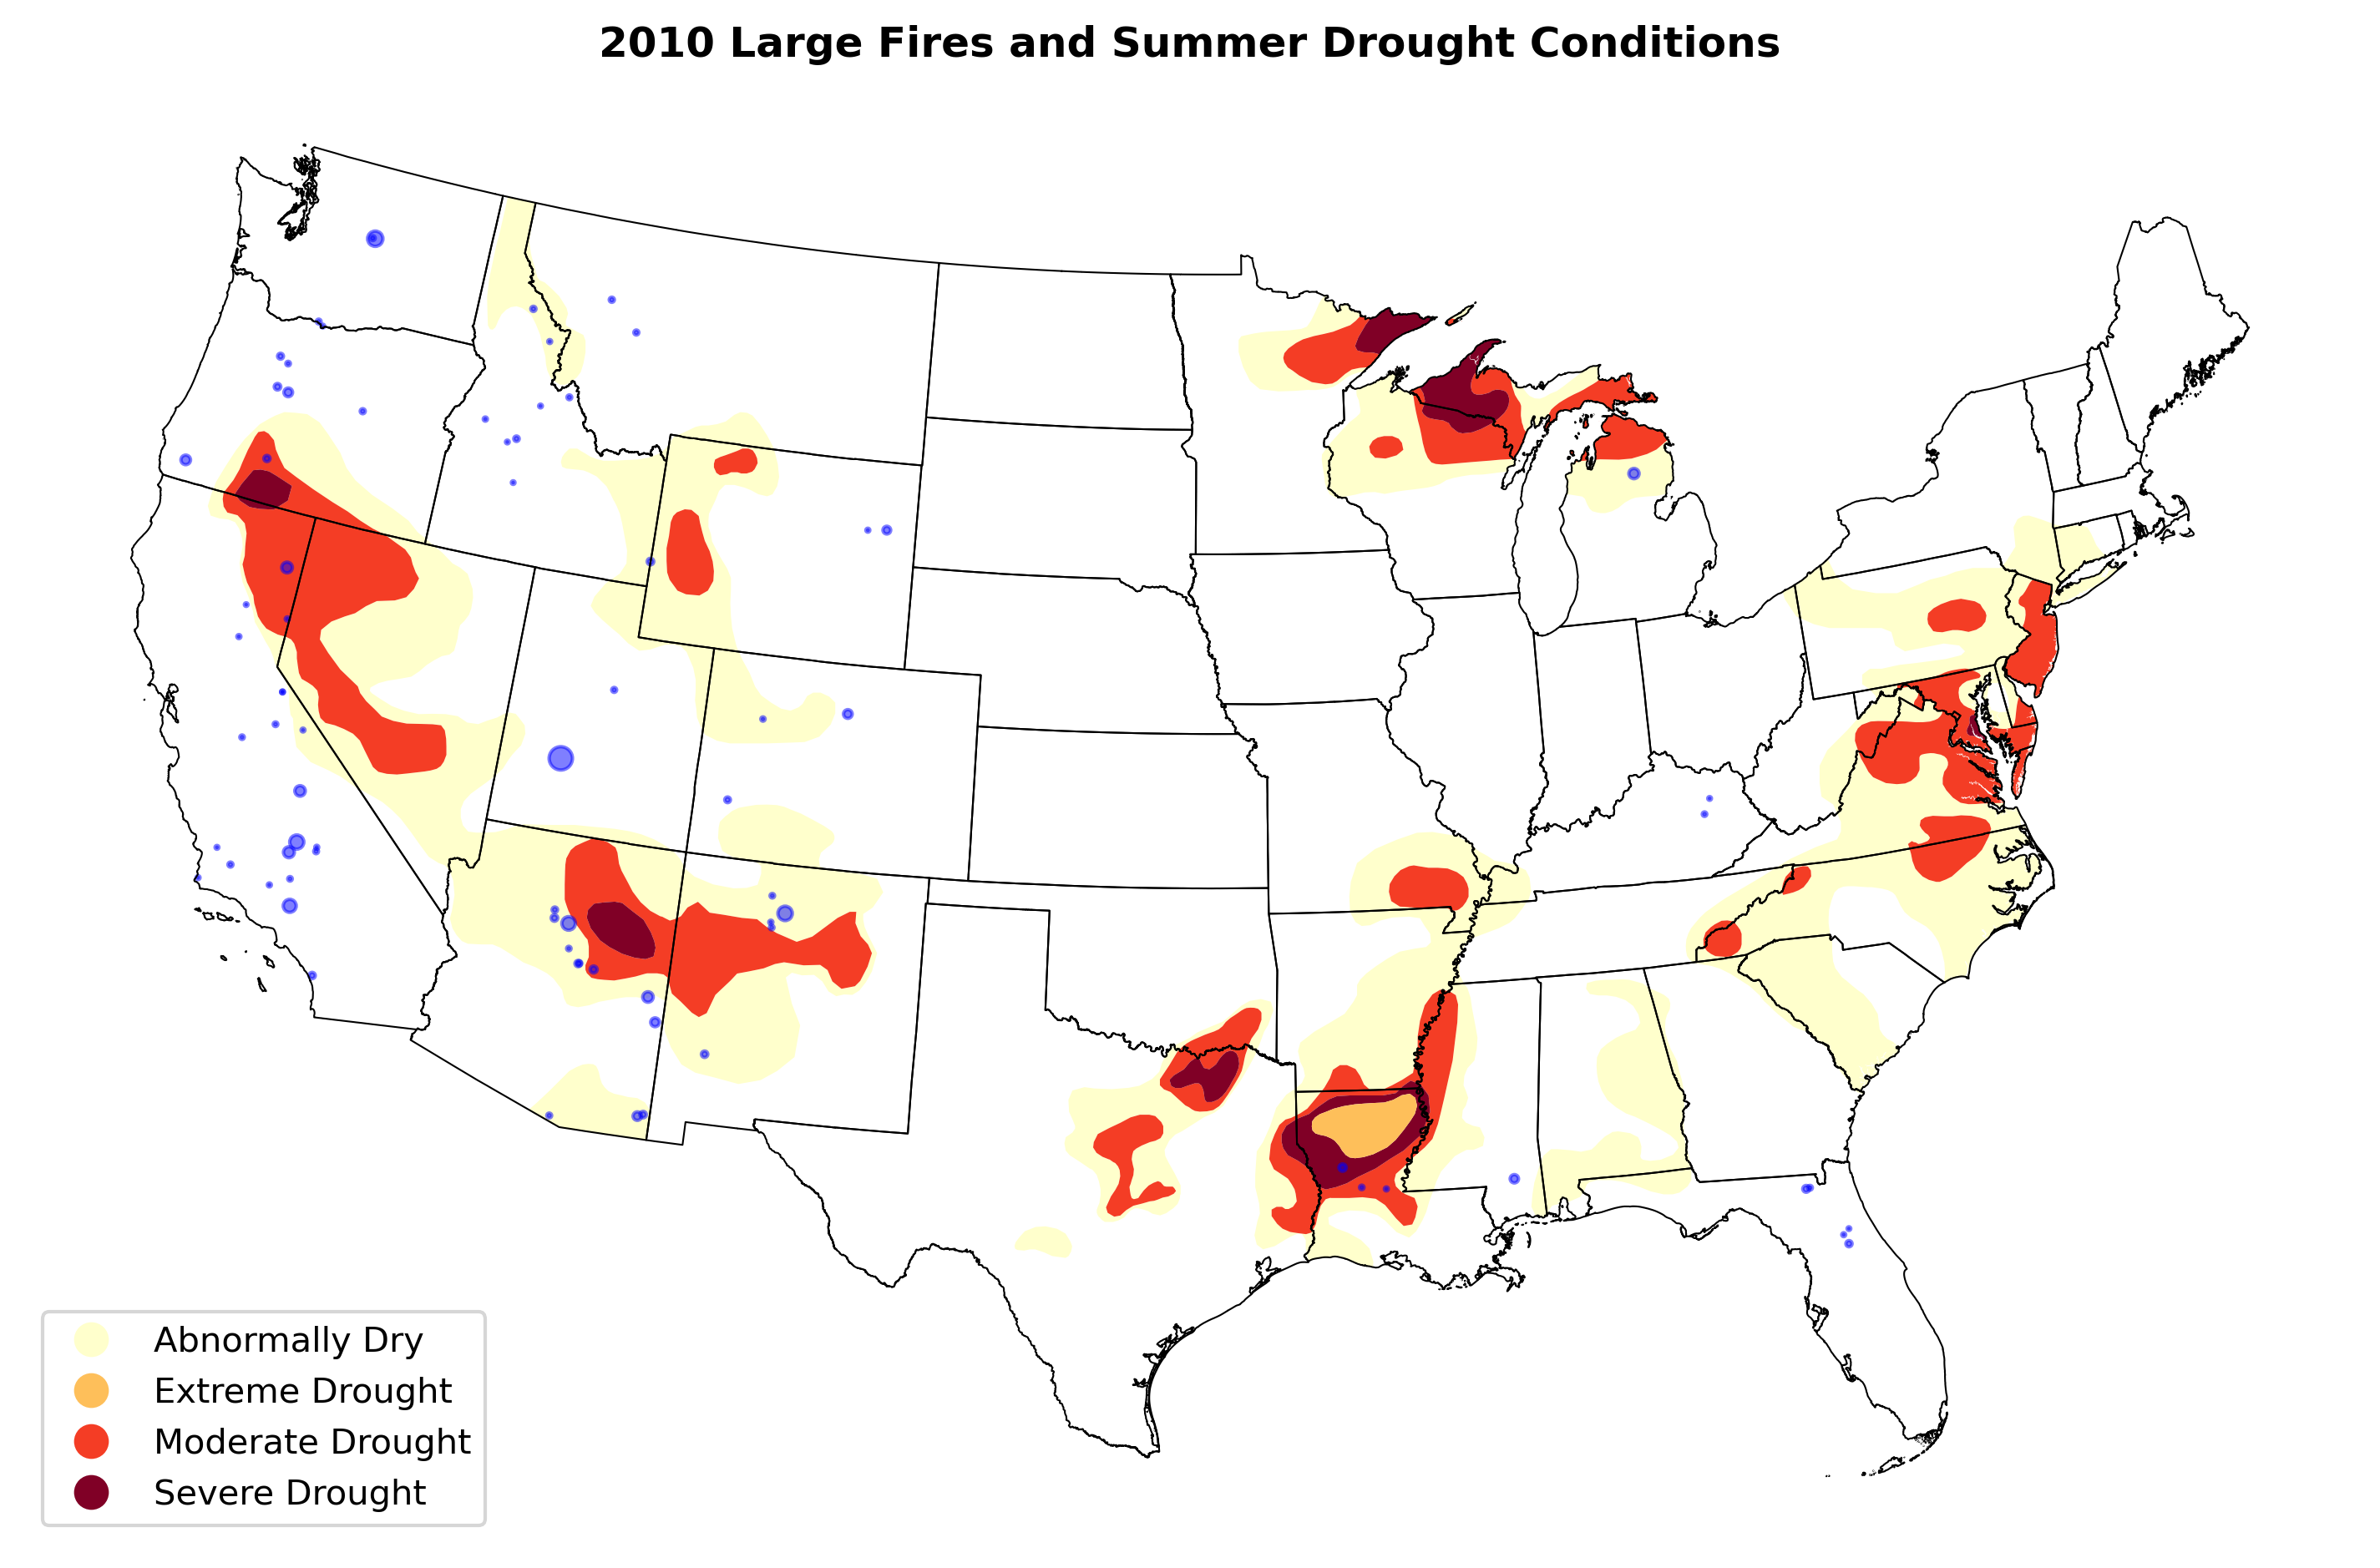

In [146]:
drought_ten_gdf = drought_ten_gdf.to_crs('EPSG:5070')
drought_ten_gdf = gpd.overlay(drought_ten_gdf, box_gdf, how="intersection")

fig, ax1 = plt.subplots(1, 1, figsize=(12, 12), dpi=300)

drought_ten_gdf.plot(ax = ax1, column = 'DM_str',legend = True, cmap = 'YlOrRd',
                      legend_kwds={'loc': 'lower left', 'fontsize': 10})
ten_gdf.plot(ax=ax1, markersize = ten_gdf['TOTALACRES']/1000, alpha = 0.5, color = 'blue')
state_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', facecolor='none')

ax1.set_title('2010 Large Fires and Summer Drought Conditions', weight= 'bold')
ax1.set_axis_off()

This map is drastically different than that of 2021. There are far fewer fires plotted and far less of the country is under drought conditions, in fact there is no extreme drought even recorded. Again, we see that most of the fires are in the west, even with a lack of drought in those areas. This would certainly suggest that drought is not the only major factor in the occurance and size of wild fires. The lower numbers of fires and acres effected, though, does again suggest that there is a correlation between the two.

#### Looking at 2000
<br>
The final year I will be looking at is one further decade in the past, 2000. Given the past research that says that wild fires and drought conditions have worsened over the years, I expect this plot to show less drought and fewer fires, given that it is data from over 20 years ago. 

In [152]:
zero_gdf = fire_gdf.loc[fire_gdf['FIREYEAR'] == 2000]
zero_gdf = zero_gdf.loc[zero_gdf['TOTALACRES'] > 1000]
zero_gdf = zero_gdf.sort_values(by='TOTALACRES', ascending = False)
zero_gdf.head()

DISCOVERYDATETIME  FIREYEAR  TOTALACRES   LATDD83   LONGDD83  \
216043  2000/07/10 00:00:00+00      2000    172135.0  45.22167 -114.49500   
213824  2000/07/31 00:00:00+00      2000    149772.0  45.15131 -115.18674   
95700                      NaN      2000    145040.0  45.96417 -114.01722   
25071   2000/08/24 00:00:00+00      2000     83508.0  43.73170 -103.88670   
493036  2000/07/22 00:00:00+00      2000     75000.0  35.86778 -118.28389   

                                geometry  
216043  POINT (-1442410.044 2611184.078)  
213824  POINT (-1497206.099 2614209.966)  
95700    POINT (-1390054.014 2685048.56)  
25071     POINT (-632026.474 2330632.75)  
493036  POINT (-1976073.445 1656679.427)

In [153]:
url_name = r'https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_20000718_M.zip'

drought_zero_gdf = gpd.read_file(url_name)

drought_zero_gdf['DM_str'] = [DM_dict[i] for i in drought_zero_gdf['DM'].values]

drought_zero_gdf.head()

OBJECTID  DM    Shape_Leng    Shape_Area  \
0         1   0  3.647263e+07  2.376510e+12   
1         2   1  2.265833e+07  1.066835e+12   
2         3   2  1.139253e+07  2.665891e+11   
3         4   3  7.404335e+06  2.611181e+11   
4         5   4  7.804344e+06  1.649494e+11   

                                            geometry                  DM_str  
0  MULTIPOLYGON (((-66.52045 17.8897, -66.52909 1...       0: Abnormally Dry  
1  MULTIPOLYGON (((-66.75891 17.98563, -66.76306 ...     1: Moderate Drought  
2  MULTIPOLYGON (((-82.49607 27.82494, -82.49711 ...       2: Severe Drought  
3  MULTIPOLYGON (((-82.81583 28.0149, -82.82516 2...      3: Extreme Drought  
4  MULTIPOLYGON (((-89.32593 29.09266, -89.3276 2...  4: Exceptional Drought

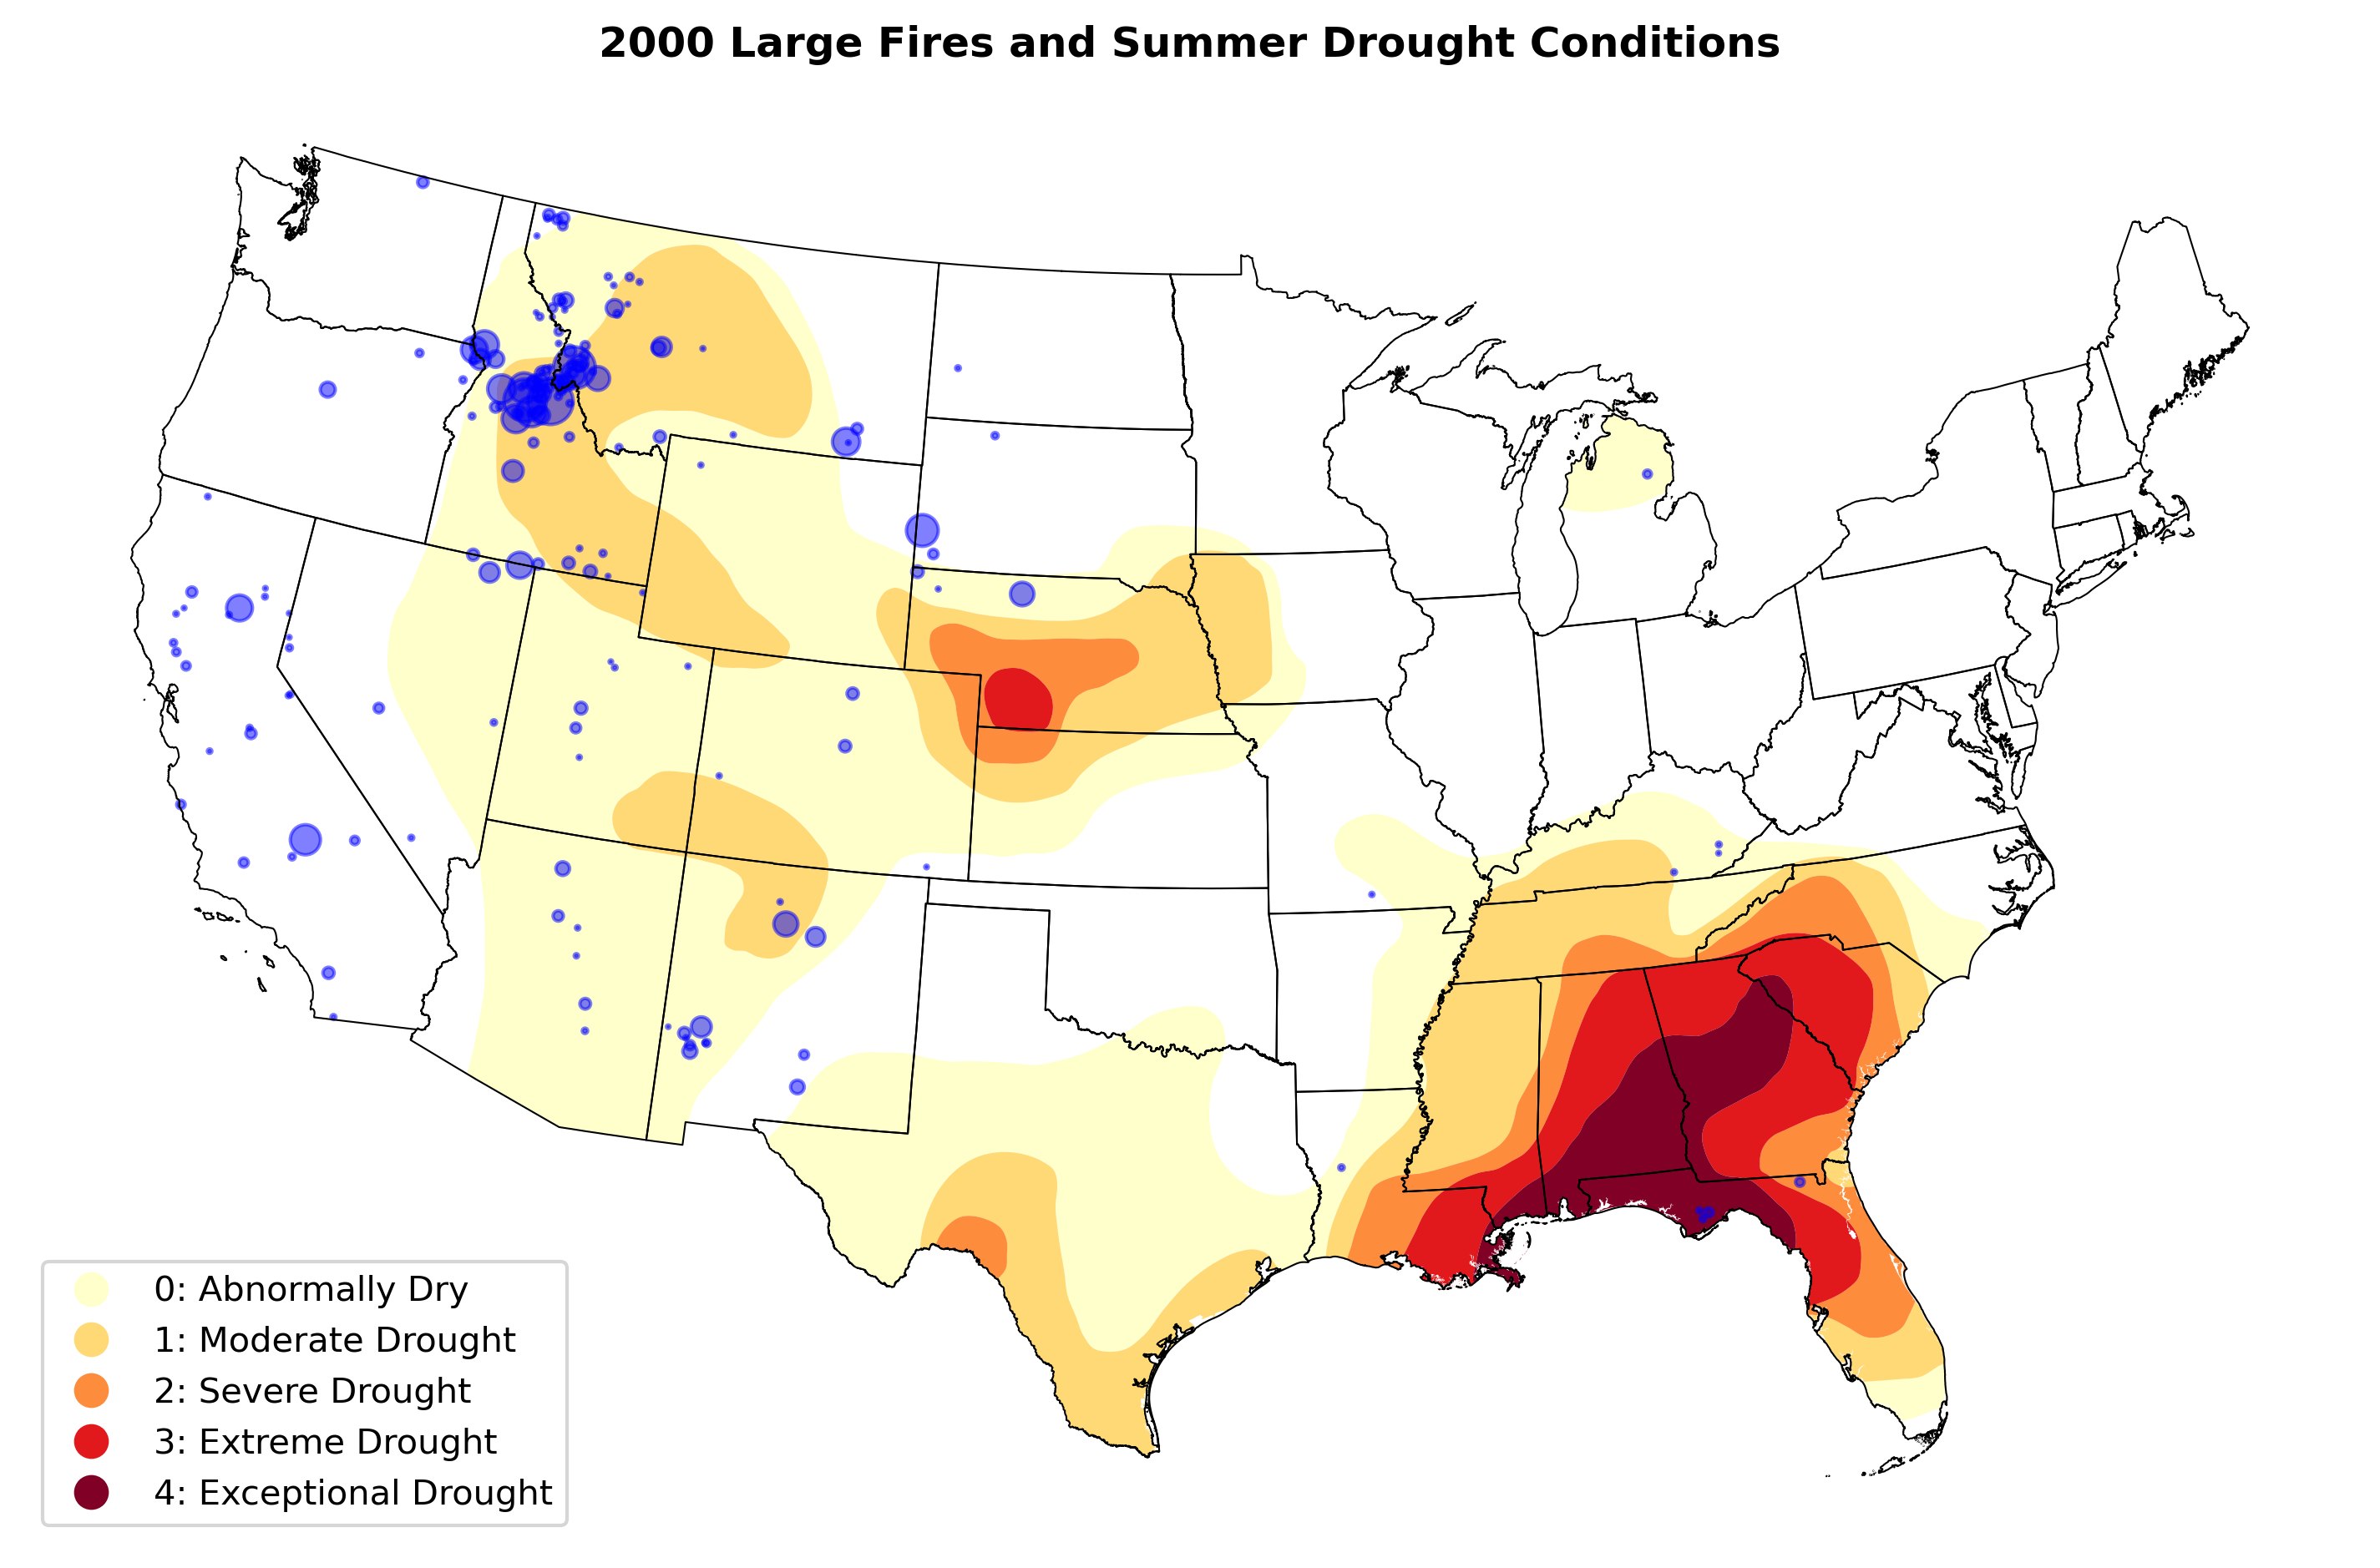

In [154]:
drought_zero_gdf = drought_zero_gdf.to_crs('EPSG:5070')
drought_zero_gdf = gpd.overlay(drought_zero_gdf, box_gdf, how="intersection")

fig, ax1 = plt.subplots(1, 1, figsize=(12, 12), dpi=300)

drought_zero_gdf.plot(ax = ax1, column = 'DM_str',legend = True, cmap = 'YlOrRd',
                      legend_kwds={'loc': 'lower left', 'fontsize': 10})
zero_gdf.plot(ax=ax1, markersize = zero_gdf['TOTALACRES']/1000, alpha = 0.5, color = 'blue')
state_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', facecolor='none')

ax1.set_title('2000 Large Fires and Summer Drought Conditions', weight= 'bold')
ax1.set_axis_off()

This plot shows a similar level of drought as 2010, but the amount of large fires is larger. There is a portion of the country in the southeast that is under bad drought conditions, yet there are still very few fires there which indicates that other geographical factors may outweigh the influence of drought when it comes to wild fires. Another interesting pattern in this plot is the clump of large fires in Idaho. This is a section that is under moderate drought and it experienced larger fires than the other years.

### Analyzing the relationship on a county basis
<br>
After seeing some visual examples of the relationship between drought and wild fires, I will now look at a more quantitative analysis to see any patterns that may exist. In order to do this, I will sort the fire data by county totals and look at some regression analysis to see the interaction between drought levels and acreage of fire. The US Drought Monitor also provides county-level data which I will use for this section. It shows the percentage of drought in that county that belongs to each category. The 2021 plot had very informative data in both the drought and fire levels, so I will be using 2021 for this analysis.

In [155]:
#Reading county drought data
drought_county_df = pd.read_csv('2021_county_drought.csv')

drought_county_df.head()

MapDate  FIPS                      County State    None     D0   D1   D2  \
0  20210713  2013      Aleutians East Borough    AK  100.00   0.00  0.0  0.0   
1  20210713  2016  Aleutians West Census Area    AK   98.98   1.02  0.0  0.0   
2  20210713  2020      Anchorage Municipality    AK   12.76  87.24  0.0  0.0   
3  20210713  2050          Bethel Census Area    AK   87.48  12.52  0.0  0.0   
4  20210713  2060         Bristol Bay Borough    AK  100.00   0.00  0.0  0.0   

    D3   D4  ValidStart    ValidEnd  StatisticFormatID  
0  0.0  0.0  2021-07-13  2021-07-19                  1  
1  0.0  0.0  2021-07-13  2021-07-19                  1  
2  0.0  0.0  2021-07-13  2021-07-19                  1  
3  0.0  0.0  2021-07-13  2021-07-19                  1  
4  0.0  0.0  2021-07-13  2021-07-19                  1

In [156]:
# Creating an average drought level that will be used in analysis
drought_county_df['D_avg'] = (((drought_county_df['D0']/100)*1) + ((drought_county_df['D1']/100)*2) 
                              + ((drought_county_df['D2']/100)*3) + ((drought_county_df['D3']/100)*2) 
                              + ((drought_county_df['D4']/100)*5))

# Converting FIPS to string to be able to merge 
drought_county_df['FIPS'] = drought_county_df['FIPS'].astype(str)
# Merging county data with county drought data
drought_county_gdf = county_gdf.merge(drought_county_df, left_on='FIPS', right_on='FIPS', how='left')

In [157]:
# Making 2021 gdf with all fire points, not just large
twone_all_gdf = fire_gdf.loc[fire_gdf['FIREYEAR'] == 2021]

# Joining fire data with county gdf to total fire acreage by county
county_fires = gpd.sjoin(twone_all_gdf, county_gdf, how="left", predicate="within")
# This is used just to see how many fires were in the county
county_fires['TOTALFIRES'] = 1
county_fires = county_fires[['TOTALACRES','FIPS','TOTALFIRES']]

county_fires = county_fires.groupby(['FIPS']).sum()
county_fires = county_fires.reset_index()

# Finally, merging datasets to get all info in one dataset
county_fires_gdf = drought_county_gdf.merge(county_fires, left_on='FIPS', right_on='FIPS', how='left')
county_fires_gdf.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID       NAME  \
0      20      161  00485044  0500000US20161  20161      Riley   
1      19      159  00465268  0500000US19159  19159   Ringgold   
2      30      009  01720111  0500000US30009  30009     Carbon   
3      16      007  00395090  0500000US16007  16007  Bear Lake   
4      55      011  01581065  0500000US55011  55011    Buffalo   

           NAMELSAD STUSPS STATE_NAME LSAD  ...      D1      D2    D3   D4  \
0      Riley County     KS     Kansas   06  ...    0.00    0.00   0.0  0.0   
1   Ringgold County     IA       Iowa   06  ...    0.00    0.00   0.0  0.0   
2     Carbon County     MT    Montana   06  ...  100.00  100.00   4.9  0.0   
3  Bear Lake County     ID      Idaho   06  ...  100.00   99.15  22.1  0.0   
4    Buffalo County     WI  Wisconsin   06  ...   49.48    0.00   0.0  0.0   

   ValidStart    ValidEnd StatisticFormatID   D_avg  TOTALACRES  TOTALFIRES  
0  2021-07-13  2021-07-19               1.0  0.3177         NaN         NaN  
1  2021-07-13  2021-07-19               1.0  0.0000         NaN         NaN  
2  2021-07-13  2021-07-19               1.0  6.0980    36550.01        34.0  
3  2021-07-13  2021-07-19               1.0  6.4165        0.90         7.0  
4  2021-07-13  2021-07-19               1.0  1.9896         NaN         NaN  

[5 rows x 29 columns]

In [158]:
# Changing NaN values to 0
county_fires_gdf['TOTALACRES'] = county_fires_gdf['TOTALACRES'].fillna(0)
county_fires_gdf['TOTALFIRES'] = county_fires_gdf['TOTALFIRES'].fillna(0)

# Normalizing fire data based on the area of the county
county_fires_gdf['norm_acres'] = county_fires_gdf['TOTALACRES'] / county_fires_gdf['ALAND']
county_fires_gdf['norm_fires'] = county_fires_gdf['TOTALFIRES'] / county_fires_gdf['ALAND']

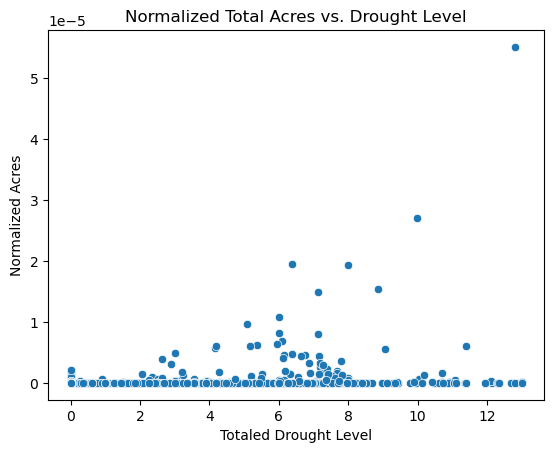

In [161]:
# Making scatterplot with drought average and normalized acres
sns.scatterplot(data=county_fires_gdf, x='D_avg', y='norm_acres')

plt.xlabel('Totaled Drought Level')
plt.ylabel('Normalized Acres')
plt.title('Normalized Total Acres vs. Drought Level')

plt.show()

This scatterplot shows the relationship between average drought level of a county and the normalized value of the total acres covered by fires in that county. It is not the clearest plot for interpretation, but it does show a positive correlation between the two variables. To take a look at the relationship when it comes to large fires, I will make another plot with fires that covered over 1,000 acres.

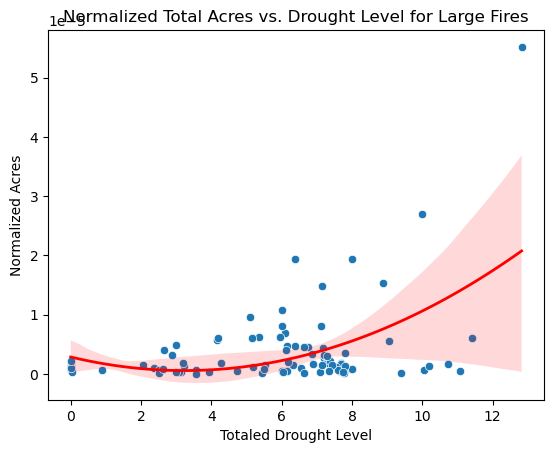

In [162]:
# Filtering fires that are more that 1000 total acres
filtered_gdf = county_fires_gdf[county_fires_gdf['TOTALACRES'] > 1000]

# Plotting
sns.scatterplot(data= filtered_gdf, x='D_avg', y='norm_acres')

# Plotting a 2nd degree regression line
sns.regplot(data=filtered_gdf, x='D_avg', y='norm_acres', scatter=False, color='red', line_kws={'lw': 2},order = 2)

plt.xlabel('Totaled Drought Level')
plt.ylabel('Normalized Acres')
plt.title('Normalized Total Acres vs. Drought Level for Large Fires')

plt.show()

This plot looks very similar to the previous one, but it gives a slightly better look into the positive correlelation between drought level and acres effected by fire. I have included a second degree line of regression to give the model some predictive power, but from the previous spatial plots and by looking at this data, it is clear that while drought definitely is correlated with fires, it needs to be taken in the context of other factors in order to be used in an accurate predictive model.

#### Looking at Total Acres Effected 
<br>
To conclude this project, I want to take a look at how the impact of fires has changed through the years. As stated earlier, previous research has shown that fires have been growing in size and frequency, with one study showing a doubling in the number of large fires since the mid 1980's (Wildfire Climate Connection). Here, I will use this wild fire data to test the validity of those claims. 

In [9]:
# Grouping fire data by year, using sum to get total acres per year
yearly_fire_df = fire_df.copy
yearly_fire_df = fire_df.groupby(['FIREYEAR']).sum()
yearly_fire_df = yearly_fire_df.reset_index()
yearly_fire_df.head()

FIREYEAR  TOTALACRES     LATDD83    LONGDD83
0      1911        42.3  1513.72155 -3684.65144
1      1912        42.6   980.44002 -2624.20926
2      1913       125.6   969.65071 -2762.95447
3      1914       582.8   959.20390 -2533.61389
4      1915        92.7  1826.27194 -5012.77201

Text(0, 0.5, 'Total Acres of Fire')

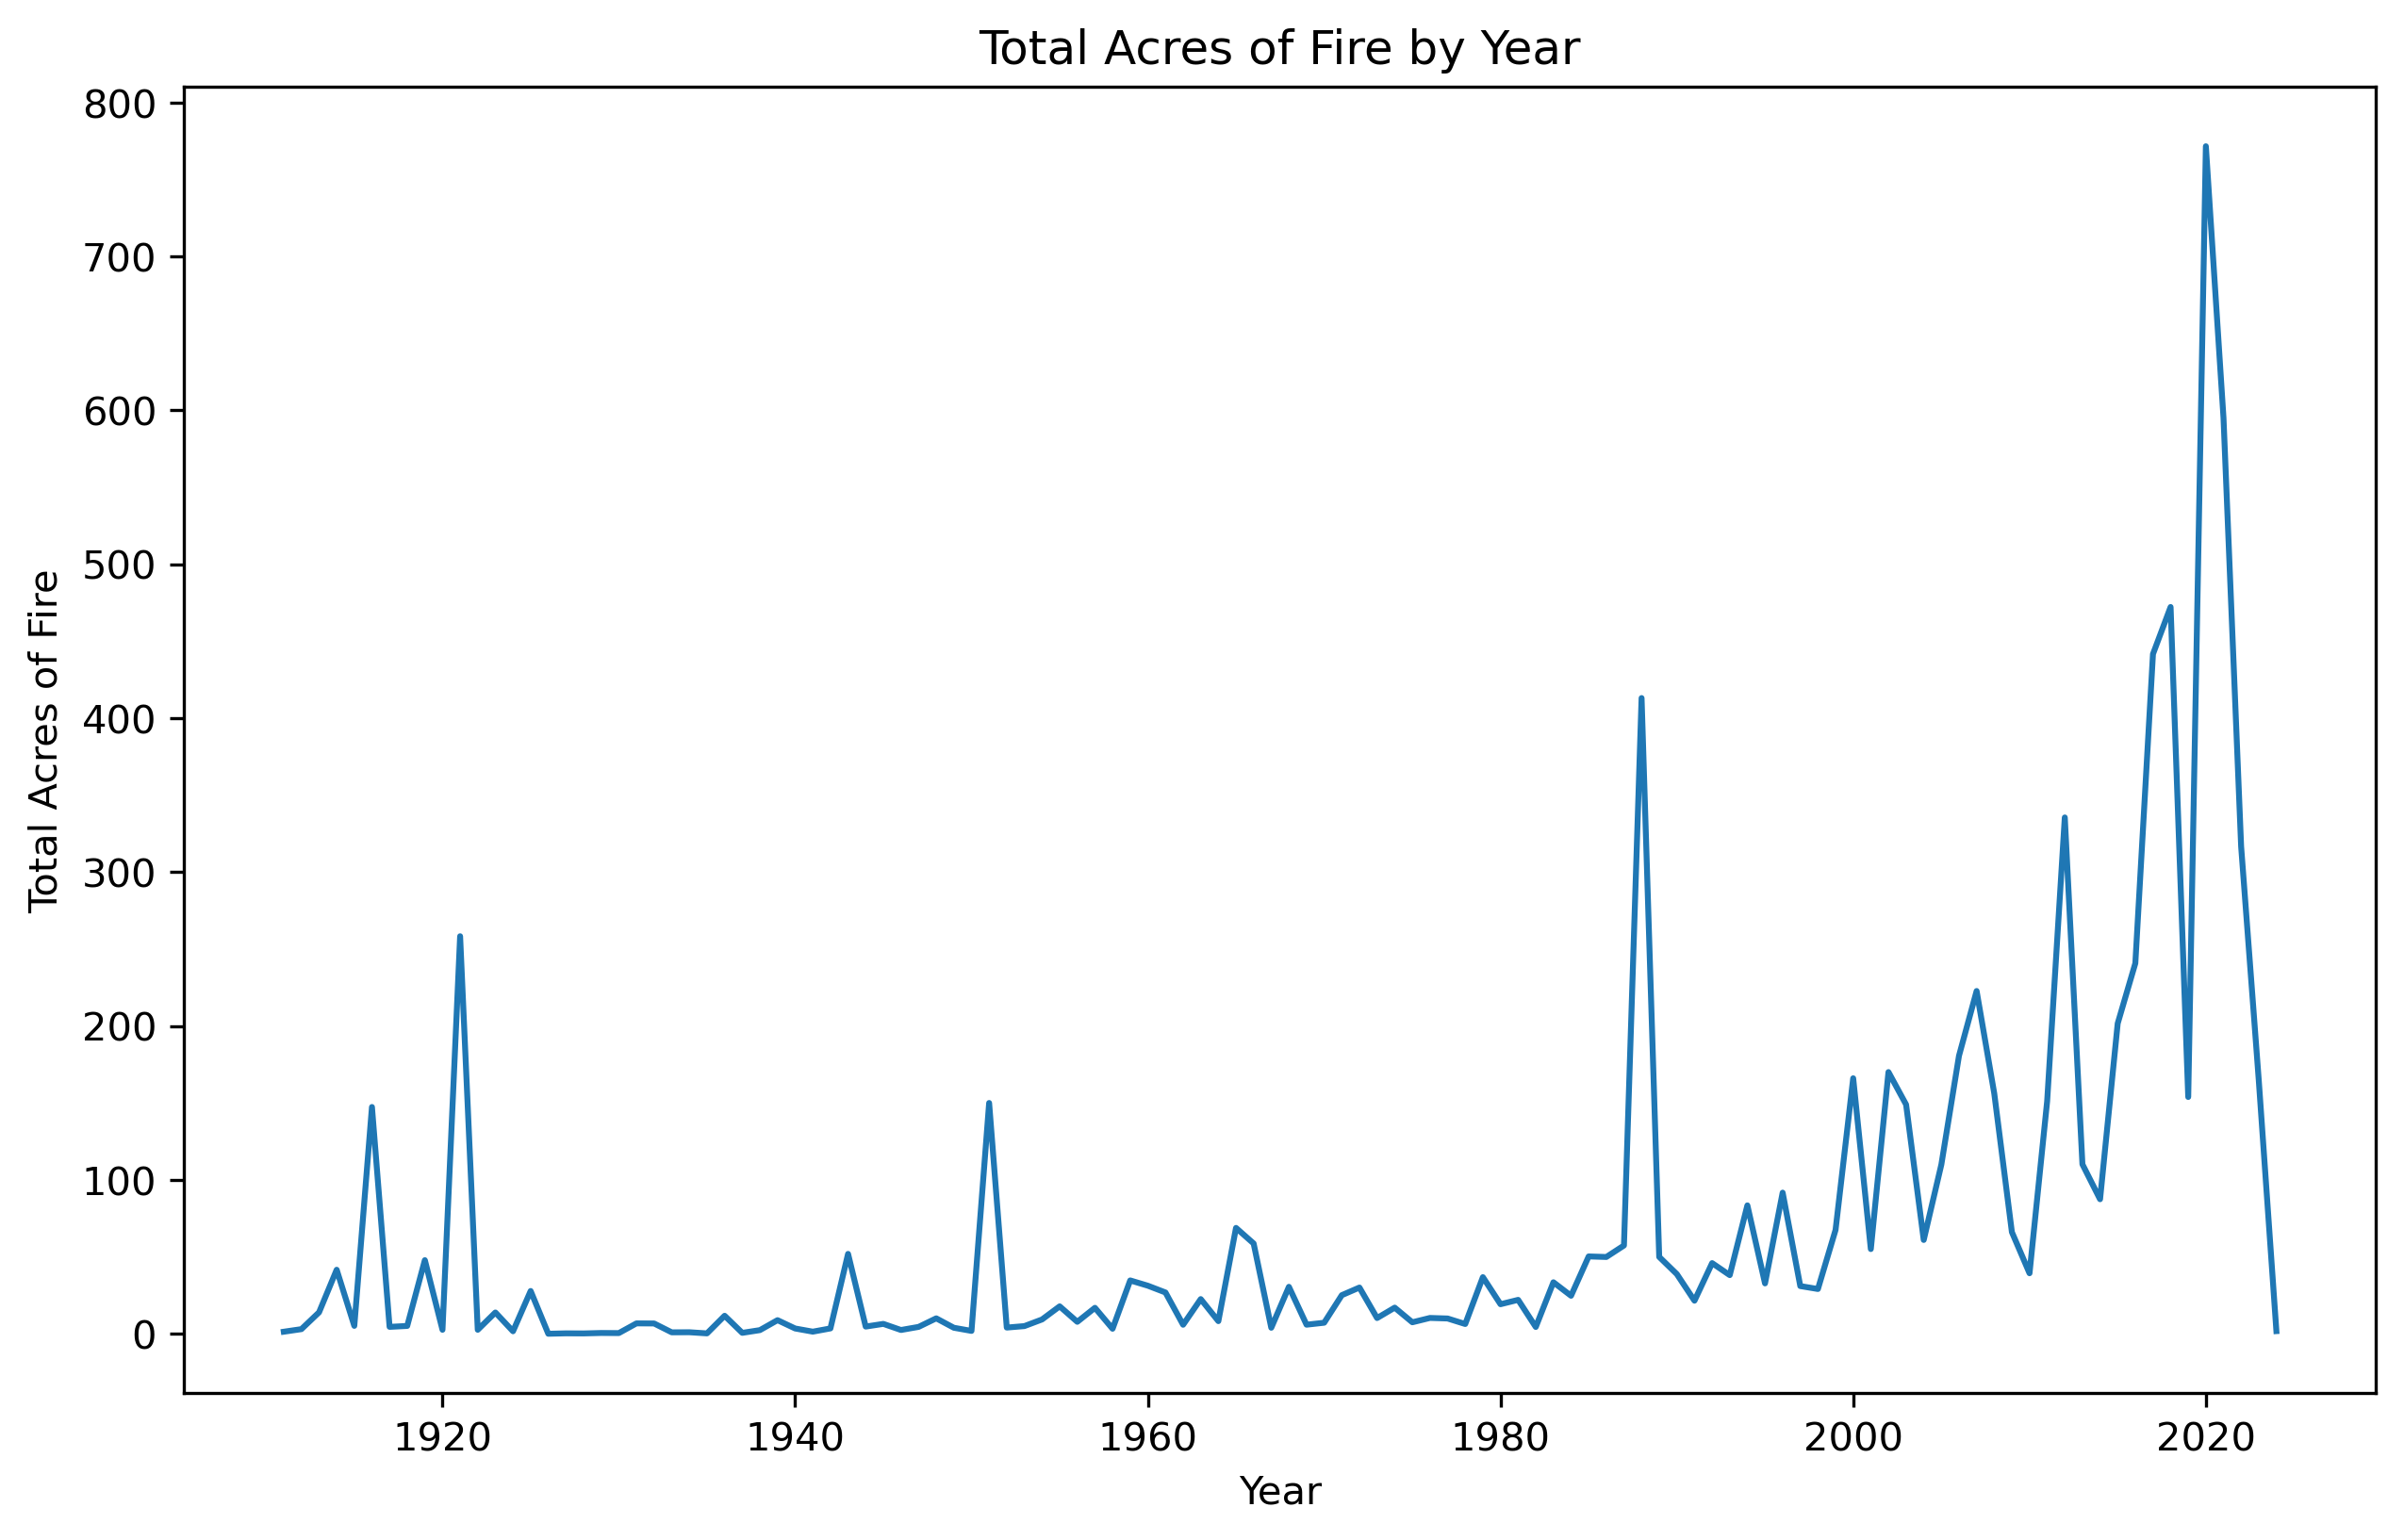

In [163]:
# Plotting total acres by year
fig, ax1 = plt.subplots(1,1, dpi = 300,figsize=(10, 6))
sns.lineplot(ax = ax1, data=fire_df, x='FIREYEAR', y='TOTALACRES',ci = None)
ax1.set_title('Total Acres of Fire by Year')
ax1.set_xlabel('Year')  
ax1.set_ylabel('Total Acres of Fire')

This line graph confirms what has been proven by previous research. There is a clear increase in the impact of wild fires, with a large increase beginning around the 1980's. An interesting aspect of this graph is that there are quite dramatic fluctuations in area from year to year, but there is nevertheless a clear increase starting in the late 20th century. This graph bears a resemblance to many climate change graphs which often show large exponential growth beginning in the mid 20th century. 

### Conclusions
<br>
This project aimed to explore the relationship between drought and wild fires in the United States. All of the analysis methods used showed the same key points. The first point is that there is a clear correlation between drought levels and the number, as well as the impacted area, of wild fires. The spatial plots showed that wild fires, by far, occur mostly in the west which was also the case for drought levels as most of the areas experiencing drought were in the west too. In each plot, there was evidence of a relationship between the to, whether that be an increase in fires under conditions of drought or a decrease in fires under no drought conditions. The quantitative plots further showed this relationship. While it is clear that other factors impact the amount and severity of fires, there is still a clear positive correlation with drought. The final plot showing the change in impact of fires over time confirms previous research and shows that there has been a steep increase in areas affected by fires starting around the 1980's. This project looked at a specific consequence of climate change, but did not get into the actual interaction between climate change and drought. It would be very interesting to see a full picture of the impacts of climate change as well as what factors impact wild fires and in future project, I hope to explore it all on a comprehensive level. 